In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Let's test the VAR model with monthly data.

Import the data (I'll first try with monthly data).

In [2]:
dvar = pd.read_csv("../Data/monthly_data.csv")

In [3]:
dvar = dvar.dropna()
dvar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 1 to 94
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 94 non-null     object 
 1   suction_tension (20cm)   94 non-null     float64
 2   suction_tension (40cm)   94 non-null     float64
 3   suction_tension (70cm)   94 non-null     float64
 4   water_temperature        94 non-null     float64
 5   barometric_pressure_qfe  94 non-null     float64
 6   dew_point                94 non-null     float64
 7   water_level              94 non-null     float64
 8   inflow_linth (m3/s)      94 non-null     float64
 9   outflow_limmat (m3/s)    94 non-null     float64
 10  precipitation (mm)       94 non-null     float64
 11  Evapotranspiration (mm)  94 non-null     float64
 12  change_rate              94 non-null     float64
dtypes: float64(12), object(1)
memory usage: 10.3+ KB


In [4]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2012-02-29 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   94 non-null     float64
 1   suction_tension (40cm)   94 non-null     float64
 2   suction_tension (70cm)   94 non-null     float64
 3   water_temperature        94 non-null     float64
 4   barometric_pressure_qfe  94 non-null     float64
 5   dew_point                94 non-null     float64
 6   water_level              94 non-null     float64
 7   inflow_linth (m3/s)      94 non-null     float64
 8   outflow_limmat (m3/s)    94 non-null     float64
 9   precipitation (mm)       94 non-null     float64
 10  Evapotranspiration (mm)  94 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.5 KB


Visualize the Time Series

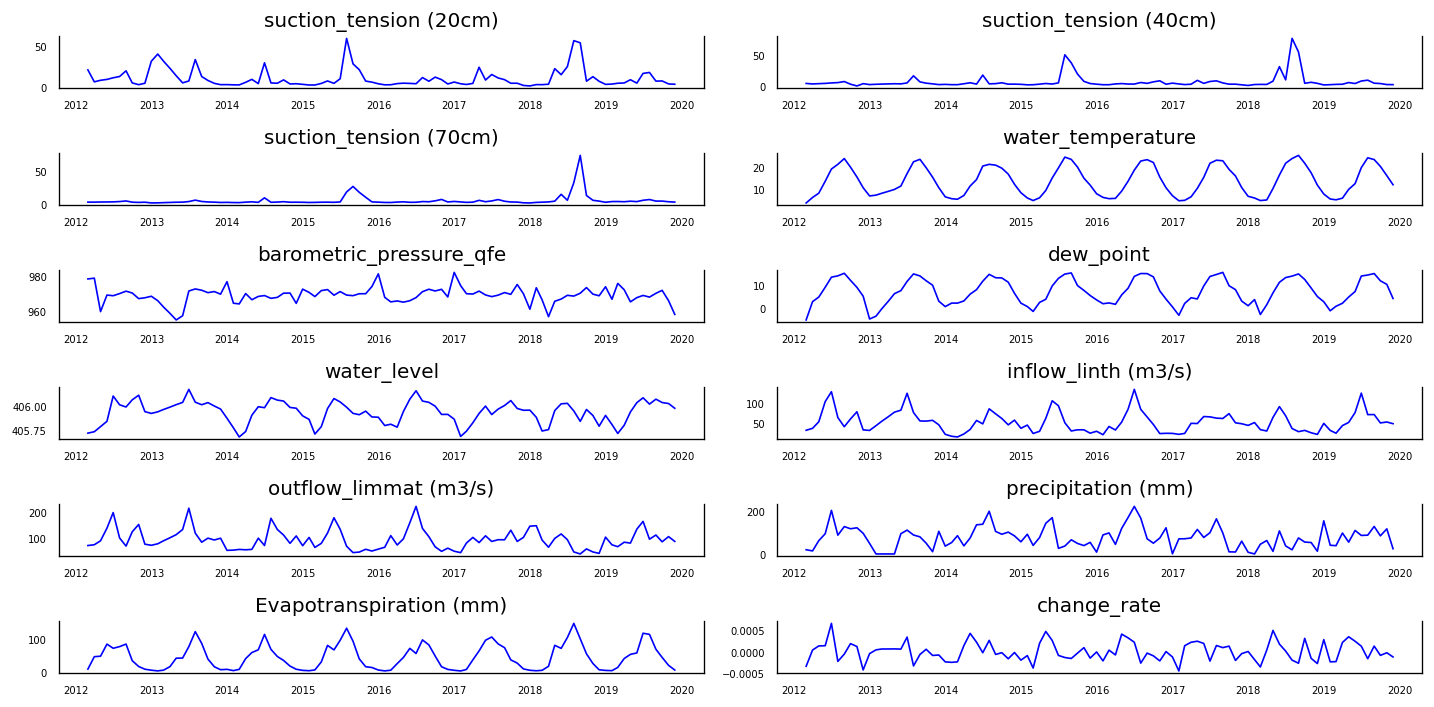

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dvar[dvar.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

As shown in the figure above, there is quite some seasonality.

Check for causality (Granger).

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    #The rows are the response variable, columns are predictors. The values in the table are the P-Values. P-Values lesser than the significance level (0.05), implies the Null Hypothesis that the coefficients of the corresponding past values is zero, that is, the X does not cause Y can be rejected.

    dvar = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dvar.columns:
        for r in dvar.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dvar.loc[r, c] = min_p_value
    dvar.columns = [var + '_x' for var in variables]
    dvar.index = [var + '_y' for var in variables]
    return dvar

grangers_causation_matrix(dvar, variables = dvar.columns) 

,suction_tension (20cm)_x,suction_tension (40cm)_x,suction_tension (70cm)_x,water_temperature_x,barometric_pressure_qfe_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x,precipitation (mm)_x,Evapotranspiration (mm)_x,change_rate_x
suction_tension (20cm)_y,1.0000,0.3587,0.0335,0.0192,0.0034,0.1014,0.0025,0.0003,0.0054,0.0057,0.0002,0.0036
suction_tension (40cm)_y,0.0361,1.0000,0.0000,0.0087,0.0182,0.0019,0.0021,0.0037,0.0555,0.0006,0.0000,0.0003
suction_tension (70cm)_y,0.0000,0.0000,1.0000,0.0216,0.0076,0.0032,0.0238,0.0624,0.4010,0.0081,0.0000,0.0183
water_temperature_y,0.0035,0.0000,0.0000,1.0000,0.0069,0.0000,0.0002,0.0000,0.0000,0.0033,0.0000,0.0000
barometric_pressure_qfe_y,0.3970,0.1907,0.1028,0.0010,1.0000,0.0063,0.1748,0.1129,0.3851,0.0364,0.0618,0.1292
dew_point_y,0.0397,0.1455,0.4942,0.0000,0.0034,1.0000,0.0088,0.0000,0.0034,0.0013,0.0000,0.0002
water_level_y,0.0154,0.0000,0.0001,0.0000,0.0004,0.0000,1.0000,0.0024,0.0006,0.0177,0.0000,0.0003
inflow_linth (m3/s)_y,0.0056,0.0000,0.0000,0.0000,0.0003,0.0000,0.0008,1.0000,0.0070,0.0425,0.0000,0.0001
outflow_limmat (m3/s)_y,0.0331,0.0001,0.0030,0.0004,0.0042,0.0010,0.0196,0.0538,1.0000,0.0050,0.0000,0.0140
precipitation (mm)_y,0.0042,0.0629,0.0413,0.0000,0.0000,0.0018,0.0039,0.0028,0.0006,1.0000,0.0008,0.0127


The row are the Response (Y) and the columns are the predictor series (X).

Cointegration test.

In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dvar, alpha=0.05): 
    out = coint_johansen(dvar,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dvar.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dvar)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  737.75    > 311.1288  =>   True
suction_tension (40cm) ::  525.22    > 263.2603  =>   True
suction_tension (70cm) ::  392.68    > 219.4051  =>   True
water_temperature ::  281.48    > 179.5199  =>   True
barometric_pressure_qfe ::  199.31    > 143.6691  =>   True
dew_point ::  130.95    > 111.7797  =>   True
water_level ::  78.24     > 83.9383   =>   False
inflow_linth (m3/s) ::  46.73     > 60.0627   =>   False
outflow_limmat (m3/s) ::  27.29     > 40.1749   =>   False
precipitation (mm) ::  10.49     > 24.2761   =>   False
Evapotranspiration (mm) ::  3.52      > 12.3212   =>   False
change_rate ::  0.31      > 4.1296    =>   False


Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Split the data

In [8]:
nobs = 24
dvar_train, dvar_test = dvar[0:-nobs], dvar[-nobs:]

print(dvar_train.shape)  
print(dvar_test.shape)

(70, 12)
(24, 12)


Stationarity.
For the VAR Model only stationary time series can be used. In order to verify it, we are going to use the ADF test.

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [10]:
for name, column in dvar_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1883
 No. Lags Chosen       = 0
 Critical value 1%     = -3.529
 Critical value 5%     = -2.904
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4938
 No. Lags Chosen       = 0
 Critical value 1%     = -3.529
 Critical value 5%     = -2.904
 Critical value 10%    = -2.59
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has un

C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\1179845333.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_train.iteritems():


All except water level are stationary. We need to difference the variables and then check the ADF one more time.

In [11]:
dvar_differenced = dvar_train.diff().dropna()
dvar_test_diff = dvar_test.diff().dropna()

In [12]:
for name, column in dvar_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6765
 No. Lags Chosen       = 0
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3255
 No. Lags Chosen       = 1
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\3428697774.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_differenced.iteritems():


Selection of the p order for the VAR.

In [13]:
model = VAR(dvar_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -2.2741840911394835
BIC :  2.817627703088057
FPE :  0.10893240225000353
HQIC:  -0.256652316508184 

Lag Order = 2
AIC :  -3.3385391148774666
BIC :  6.533218882395516
FPE :  0.05589191792140182
HQIC:  0.5677402157152986 

Lag Order = 3
AIC :  -7.244183150623533
BIC :  7.486221477554235
FPE :  0.004129781800345414
HQIC:  -1.4235001642551453 

Lag Order = 4
AIC :  -18.15535476985994
BIC :  1.5144869947344333
FPE :  3.099264451579495e-06
HQIC:  -10.394341216985907 

Lag Order = 5
AIC :  -237.36546374768824
BIC :  -212.67323848176198
FPE :  2.6089618337602117e-94
HQIC:  -227.63794894740204 

Lag Order = 6
AIC :  -674.1740329332025
BIC :  -644.3742548329012
FPE :  5.431025229151828e-292
HQIC:  -662.4536345494189 

Lag Order = 7
AIC :  -717.6113140609085
BIC :  -682.6165225650054
FPE :  0.0
HQIC:  -703.8714760319368 

Lag Order = 8
AIC :  -727.8189971983384
BIC :  -687.5393713311623
FPE :  0.0
HQIC:  -712.0330343322263 

Lag Order = 9
AIC :  -725.8928464691866
BIC :  -680

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Let's try lag 3.

Train the model with the lag 3.

In [14]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Nov, 2022
Time:                     12:30:04
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    1.51449
Nobs:                     65.0000    HQIC:                  -10.3943
Log likelihood:           71.2770    FPE:                3.09926e-06
AIC:                     -18.1554    Det(Omega_mle):     3.65899e-09
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.510192         1.074993           -0.475           0.635
L1.suction_tension (20cm)          -1.783887         0.597459           -2.986    

Residuals with Durbin Watson Statistic

In [15]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dvar.columns, out):
    print(col, ':', round(val, 2))

suction_tension (20cm) : 1.97
suction_tension (40cm) : 2.09
suction_tension (70cm) : 2.0
water_temperature : 2.1
barometric_pressure_qfe : 2.03
dew_point : 1.87
water_level : 1.72
inflow_linth (m3/s) : 2.07
outflow_limmat (m3/s) : 1.9
precipitation (mm) : 1.78
Evapotranspiration (mm) : 2.07
change_rate : 1.72


CHECK THE MEANING

Forecasting

In [16]:
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = dvar_differenced.values[-lag_order:]
forecast_input

4


array([[-2.09583333e+00, -3.34194483e+00, -2.54197873e+00,
        -2.62065607e-01,  1.43534946e+00,  9.33955509e-01,
         3.78090034e-02, -9.43165568e-01, -3.30458789e-01,
        -6.63000000e+01, -1.16100000e+01, -4.90754006e-05],
       [-4.46136050e+00, -1.98757469e+00, -1.13229370e+00,
        -3.85195242e+00, -9.86246147e-01, -5.93136725e+00,
         5.19411462e-02,  1.20421377e+01,  3.69906792e+01,
        -8.80000000e+01, -3.76500000e+01,  3.47990917e-05],
       [ 2.28649912e-02, -6.62040338e-03, -1.29874483e-01,
        -2.98199683e+00,  5.49132470e+00, -1.73545980e+00,
        -8.33471405e-02, -2.27897524e+01, -4.33291147e+01,
        -7.00000000e-01, -9.96000000e+00, -3.33191633e-04],
       [-2.73175662e+00, -1.05441048e+00, -1.06034517e+00,
        -5.20708647e+00, -5.16991541e+00, -5.08467213e+00,
        -1.88699181e-02, -2.25980943e+00,  1.55981739e+01,
         5.06000000e+01, -1.79500000e+01,  1.58778898e-04]])

In [17]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dvar_forecast = pd.DataFrame(fc, index=dvar.index[-nobs:], columns=dvar.columns + '_1d')
dvar_forecast

,suction_tension (20cm)_1d,suction_tension (40cm)_1d,suction_tension (70cm)_1d,water_temperature_1d,barometric_pressure_qfe_1d,dew_point_1d,water_level_1d,inflow_linth (m3/s)_1d,outflow_limmat (m3/s)_1d,precipitation (mm)_1d,Evapotranspiration (mm)_1d,change_rate_1d
datetime,,,,,,,,,,,,
2017-12-31,5.656617,5.870180,3.435361,-2.289085,-1.338407,0.049946,-0.149583,-20.420059,-51.113790,-25.211476,-1.265703,-0.000322
2018-01-31,-16.872773,-14.941732,-5.732413,-1.499354,1.847103,1.097923,0.095426,51.923390,100.426614,11.591042,-6.202972,0.000604
2018-02-28,31.615487,20.258398,4.756647,2.144533,-1.289954,-2.099257,-0.038485,-15.035414,-48.783596,-71.302114,46.611550,-0.000330
2018-03-31,-12.157104,-2.885349,3.061852,2.565841,-0.626743,5.189450,-0.016480,-11.817842,-20.164954,33.859324,11.627978,0.000054
2018-04-30,2.820942,0.488122,-0.107991,2.931883,0.060850,0.641029,-0.047129,-23.452325,-51.068594,14.229852,20.402186,-0.000075
2018-05-31,-6.044354,-2.901566,-0.352461,1.914619,-3.077019,3.325766,0.167083,50.899470,101.712966,72.421706,-16.053458,0.000528
2018-06-30,-12.547872,-8.060632,-4.541892,2.722864,4.936610,3.159557,0.051623,12.280418,16.068886,0.494390,6.628344,-0.000284
2018-07-31,13.075227,10.271794,1.876972,0.989646,7.323458,-0.808757,0.029695,-11.142602,-18.264362,-49.537890,15.113910,-0.000054
2018-08-31,-2.841922,-1.390866,1.186581,-0.328831,-5.295907,-1.642949,-0.110557,-36.993021,-62.246783,11.296445,-8.866840,-0.000346


In [18]:
def invert_transformation(dvar_train, dvar_forecast, first_diff=False): #first diff? or second diff?
    dvar_fc = dvar_forecast.copy()
    columns = dvar_train.columns
    for col in columns:        
        dvar_fc[str(col)+'_forecast'] = dvar_train[col].iloc[-1] + dvar_fc[str(col)+'_1d'].cumsum()
    return dvar_fc

In [19]:
dvar_results = invert_transformation(dvar_train, dvar_forecast, first_diff=True)        
dvar_results.loc[:, ['suction_tension (20cm)_forecast', 'suction_tension (40cm)_forecast', 'suction_tension (70cm)_forecast', 'water_temperature_forecast', 'barometric_pressure_qfe_forecast',
                   'dew_point_forecast', 'water_level_forecast', 'inflow_linth (m3/s)_forecast', 'outflow_limmat (m3/s)_forecast', 'precipitation (mm)_forecast', 'Evapotranspiration (mm)_forecast', 'change_rate_forecast']]

,suction_tension (20cm)_forecast,suction_tension (40cm)_forecast,suction_tension (70cm)_forecast,water_temperature_forecast,barometric_pressure_qfe_forecast,dew_point_forecast,water_level_forecast,inflow_linth (m3/s)_forecast,outflow_limmat (m3/s)_forecast,precipitation (mm)_forecast,Evapotranspiration (mm)_forecast,change_rate_forecast
datetime,,,,,,,,,,,,
2017-12-31,7.325478,7.810207,4.770600,8.407451,968.508105,2.933867,405.805610,28.556187,51.672198,34.588524,6.864297,-0.000369
2018-01-31,-9.547296,-7.131525,-0.961813,6.908097,970.355208,4.031790,405.901037,80.479577,152.098812,46.179566,0.661324,0.000235
2018-02-28,22.068192,13.126873,3.794834,9.052629,969.065254,1.932533,405.862552,65.444162,103.315216,-25.122548,47.272874,-0.000095
2018-03-31,9.911087,10.241524,6.856686,11.618471,968.438512,7.121984,405.846072,53.626321,83.150262,8.736776,58.900851,-0.000041
2018-04-30,12.732030,10.729646,6.748695,14.550354,968.499362,7.763013,405.798943,30.173996,32.081668,22.966628,79.303037,-0.000116
2018-05-31,6.687676,7.828080,6.396234,16.464973,965.422342,11.088779,405.966027,81.073465,133.794634,95.388334,63.249579,0.000412
2018-06-30,-5.860196,-0.232552,1.854342,19.187836,970.358952,14.248336,406.017650,93.353884,149.863520,95.882723,69.877924,0.000127
2018-07-31,7.215031,10.039242,3.731314,20.177482,977.682410,13.439579,406.047344,82.211282,131.599159,46.344833,84.991834,0.000073
2018-08-31,4.373109,8.648376,4.917895,19.848651,972.386504,11.796629,405.936787,45.218261,69.352376,57.641278,76.124994,-0.000272


In [20]:
def invert_transformation(dvar_test, dvar_test_diff, first_diff=False): #first diff? or second diff?
    dvar_test1 = dvar_test_diff.copy()
    columns = dvar_test.columns
    for col in columns:        
        dvar_test1[col]= dvar_test[col].iloc[-1] + dvar_test1[col].cumsum()
    return dvar_test1

In [21]:
dvar_test1 = invert_transformation(dvar_test, dvar_test_diff, first_diff=True)        
dvar_test1

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm),change_rate
datetime,,,,,,,,,,,,
2018-01-31,4.822534,3.744232,3.232534,11.186157,970.274612,6.775426,405.900916,56.157657,88.960001,16.6,3.27,-3.120170e-04
2018-02-28,4.724818,3.932705,3.563803,10.045061,963.533387,0.142600,405.756424,38.555151,33.648923,62.0,4.63,-4.827717e-04
2018-03-31,5.289634,3.871124,3.943675,10.314851,954.140952,4.513865,405.771574,35.252591,6.251168,79.4,17.04,-8.943655e-05
2018-04-30,24.573493,9.123186,5.105376,15.463632,962.735391,9.759509,405.971677,68.946130,40.139414,28.7,81.82,3.663899e-04
2018-05-31,17.114708,32.263028,15.411998,21.533532,963.976118,14.451134,406.042678,95.548608,57.244886,124.4,72.35,4.812381e-05
2018-06-30,27.130316,11.234596,6.417788,26.830846,966.060428,16.555954,406.047833,72.937816,35.161856,54.2,106.00,-1.140783e-04
2018-07-31,59.274116,77.553844,32.965633,28.949196,965.628964,17.203377,405.967565,41.294987,-11.967983,36.1,149.47,-3.244680e-04
2018-08-31,56.626918,55.834805,74.158182,30.370747,967.243888,18.171691,405.858148,33.615980,-19.728056,91.6,101.94,-3.963100e-04
2018-09-30,9.022346,5.710897,13.655502,26.838987,970.401747,15.708656,405.983175,36.752898,-0.264205,72.2,55.59,1.812960e-04


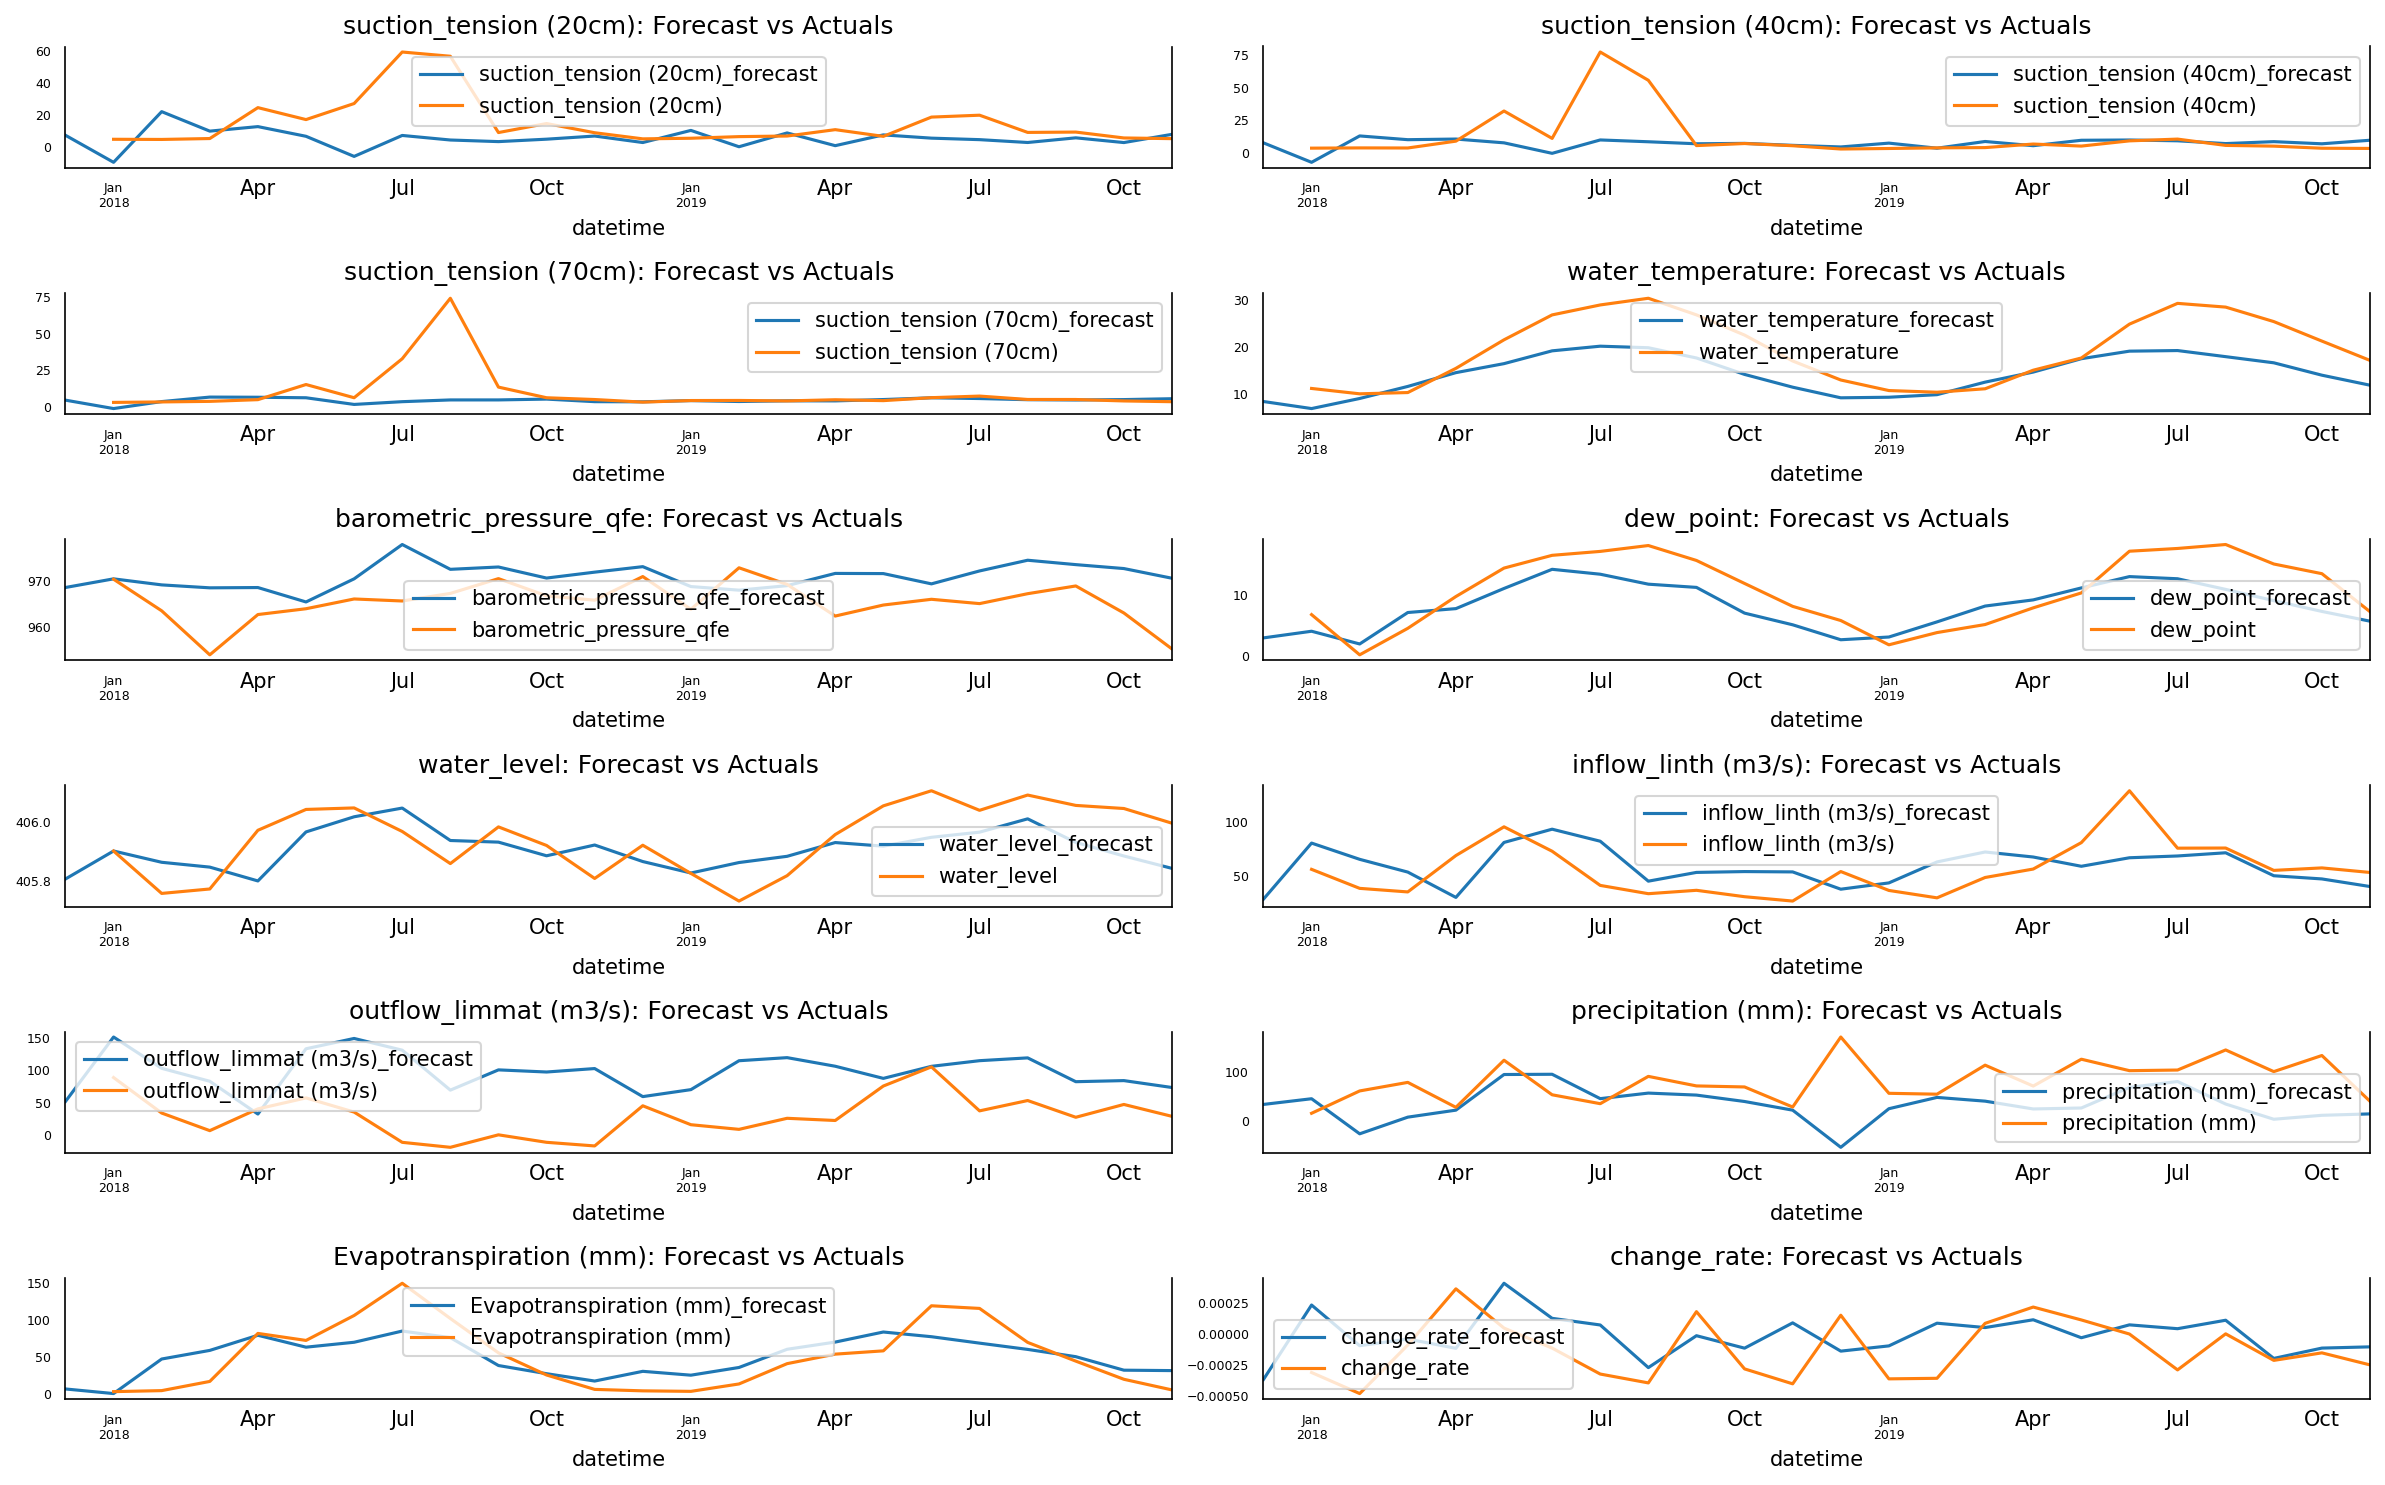

In [22]:
fig, axes = plt.subplots(nrows=int(len(dvar.columns)/2), ncols=2, dpi=150, figsize=(16,10))
for i, (col,ax) in enumerate(zip(dvar.columns, axes.flatten())):
    dvar_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dvar_test1[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()


<AxesSubplot: xlabel='datetime'>

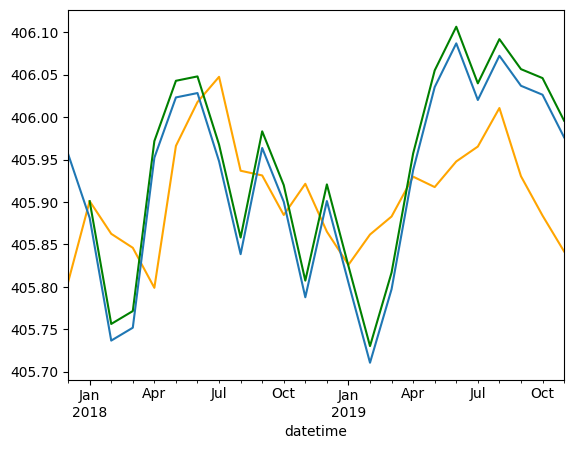

In [29]:
import matplotlib.pyplot as plt
dvar_results["water_level_forecast"].plot(color="orange")
dvar_test1["water_level"].plot(color="green")
dvar_test["water_level"].plot()


<AxesSubplot: xlabel='datetime'>

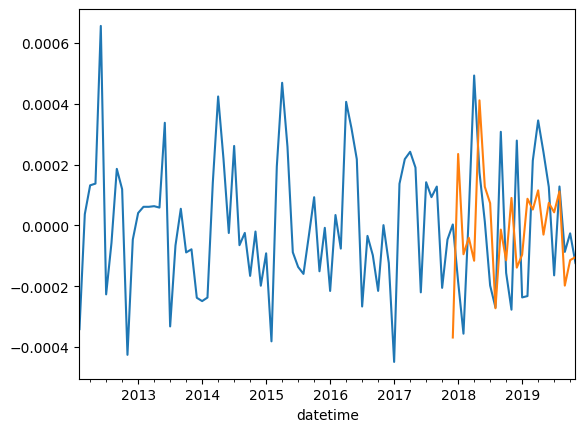

In [24]:
import matplotlib.pyplot as plt
dvar["change_rate"].plot()
dvar_results["change_rate_forecast"].plot()

In [25]:
# some error measures to evaluate the model performance
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: water_level')
accuracy_prod = forecast_accuracy(dvar_results['water_level_forecast'].values, dvar_test['water_level'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: water_level
mape :  0.0002
me :  -0.0163
mae :  0.0853
mpe :  -0.0
rmse :  0.0989
corr :  0.4729
minmax :  0.0002


C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\522686556.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\522686556.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [41]:
# I had to drop the first row because the test1 data set only had 23 rows instead of 24 like the normal test set and the predictions (dvar results)
results_23 = dvar_results.iloc[1:,]

In [43]:
print('Forecast Accuracy of: water_level with differenced and invertly transformed test data')
accuracy_prod = forecast_accuracy(results_23['water_level_forecast'].values, dvar_test1['water_level'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: water_level with differenced and invertly transformed test data
mape :  0.0002
me :  -0.03
mae :  0.0867
mpe :  -0.0001
rmse :  0.1001
corr :  0.5243
minmax :  0.0002


C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\522686556.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\lucal\AppData\Local\Temp\ipykernel_25992\522686556.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
